In [22]:
from scipy.io import loadmat
import os
from datetime import datetime
import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calculate_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))
    
    
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [3]:
def load_data(data_dir, dataset):
    
    meta = loadmat(os.path.join(data_dir, "{}.mat".format(dataset)))
    
    full_path = meta[dataset][0, 0]["full_path"][0]
    
    dob = meta[dataset][0, 0]["dob"][0]
    
    photo_taken = meta[dataset][0, 0]["photo_taken"][0]
    
    name = meta[dataset][0, 0]["name"][0]
    
    age = np.array([calculate_age(photo_taken[i], dob[i]) for i in range(len(dob))])
    
    images = []
    for img_path in tqdm_notebook(full_path):
        images.append(img_path[0])
    
    images = np.array(images)
    
    return images, age

In [41]:
def load_images(data_dir, image_paths, image_shape):
    
    images = None
    num_images = len(image_paths)
    
    for i, image_path in tqdm_notebook(enumerate(image_paths), total=num_images):
    
        try:
            # Load image
            loaded_image = image.load_img(os.path.join(data_dir, image_path), target_size=image_shape)
            
            # Convert PIL image to numpy ndarray
            loaded_image = image.img_to_array(loaded_image)

            # Add another dimension (Add batch dimension)
            loaded_image = np.expand_dims(loaded_image, axis=0)

            
            if images is None:
                images = loaded_image
            else:
                images = np.concatenate([images, loaded_image], axis=0)
        except Exception as e:
            print("Error:", i, e)

    return images

In [ ]:
def normalize_images(images):
    

In [42]:
#images = load_images("data/wiki_crop")
images, ages = load_data("data/wiki_crop", "wiki")

In [43]:
n = 500
images = images[:n]
ages = images[:n]
print(images.shape)
print(ages.shape)

(500,)
(500,)


In [44]:
image_shape = (64, 64, 3)

loaded_images = load_images("data/wiki_crop", images, (image_shape[0], image_shape[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 64, 64, 3)


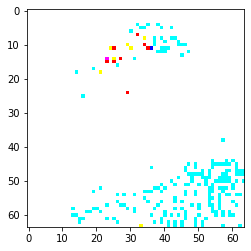

In [52]:
print(loaded_images.shape)
img = loaded_images[0]
#plt.imshow(img, )